## ION CHANNEL DOSE RESPONSE

by Anastasia Abashidze


Blavatnik Center for Drug Discovery
***

## Introduction
  
#### Dose Response


<div align="justify"> In drug discovery, most dose-response curves are satisfactorily described by a classical Hill equation (4 parameters sigmoidal function). Hill equation reflects the cellular response to the ligand: the physiological output of the system, in our case it is fluorescence. The response is calculated as follows:</div>
<img style="float: left; margin-right:700px"  width="350" src="hts_images/hill.png" > 

where EC50 reffered to the drug concentration that produces a 50% maximal response (in our case inhibition). Image from https://www.discoverx.com

<img style="float: left; margin-right:700px"  width="350" src="hts_images/dose_response.png" >    




Image from https://greek.doctor/wp-content/uploads/2018/09/word-image-12-768x462.png


<div align="justify"> Efficacy is a measure of how “effective” the drug is. It measures how large of a cellular response the drug can induce in the tissue, which roughly translates to how severe of a condition or symptom the drug can treat. </div>       

<div align="justify">Potency is a measure of how much of a drug you need to get the desired effect. It’s measured by the constant ED50. The lower the ED50, the more potent the drug is. It depends on the affinity and the intrinsic efficacy.</div>       

<div align="justify">A high potency is always good because when a drug is potent even a low concentration can give a satisfactory therapeutic effect. By allowing the use of low concentrations potent drugs reduce the risk for adverse effects.</div> 

#### Assay Data

<div align="justify"> As in previous experiment (cherry picking), we work with calcium influx assay. We nornalize fluorescence data by dividing the fluorescence values at each time point in each well by the value of that well’s first time point (F/F0). In all instances, we multiply F/F0 value by average initial fluorescent values for all wells on the plate to arrive at “normalized fluorescence intensity”. 
In all instances, we subtract the normalized values at each time point from the vehicle-control condition (DMSO) from the values obtained under the test compound conditions to reveal time-dependent, test condition-mediated changes. Calcium flux data then quantified by measuring the slope of the increase in fluorescence over a 6 s period after the addition of stimulus buffer (ABP).</div>
In this experiment,  we have only one compound with 8 different concentrations.

#### References
Computational tools for fitting the Hill equation to dose-response curves. Gadagkar and Call, 2015. DOI:10.4172/2161-1459.S1.007

https://en.wikipedia.org/wiki/Hill_equation_(biochemistry)

https://greek.doctor/pharmacology-1/5-characterisation-of-agonist-receptor-interaction-occupancy-affinity-dose-response-curve-potency-efficacy/

***

## The Workflow

[Import Packages and create Output Folder](#import)   
[Load Data](#load_data)      
[Nomalizing Fluorescence](#blank)    
[generate Time Series Table](#time_series)   
[Add Layout](#layout) 
[Plot Kinetics](#plot_raw)   
[Get Slopes](#slopes)  
[Calculate % Inhibition](#inhibition)


[Running QC](#qc) 
 - [Building Heatmap function](#heatmap)
 - [Get Statistics](#stat)


[Fitting Dose-Response](#dr)   
[Polynomial Fit](#poly)   
[Conclusions](#conclusions)
 ***

### Import Packages and create Output Folder
<a id="import"></a>

In [1]:
from nbdev.showdoc import *
import os
import sys
sys.path.append('..//')
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib as mpl
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'notebook', style = 'white', palette = 'dark')
import simplydrug.core as sd

#### Create folder to save the output

In [2]:
path = ('ion_channel_dr_output') 
if not os.path.exists(path):
    os.mkdir(path)
    print('Output folder created')

### Load Data
<a id="load_data"></a>

In [3]:
data_path = 'hts_data//dr_data.xlsx'
layout_path = 'hts_data//dr_layout.xlsx'

data = pd.DataFrame(pd.ExcelFile(data_path).parse(0))   
print('Data table size: ' + str(data.shape))
display(data.head())

Data table size: (60, 27)


,Well,0s,6s,12s,18s,25s,31s,37s,43s,49s,...,98s,104s,110s,117s,123s,129s,135s,141s,147s,153s
0,B2,15808,15785,15489,15042,14720,14360,14367,13941,13671,...,13599,13140,13171,13375,13490,13273,13280,13401,13468,13034
1,B3,13723,13698,13311,13202,13157,12749,12532,12456,12351,...,11828,12110,12245,11882,12189,11909,11722,11891,11697,11786
2,B4,17024,17342,16339,16698,15984,15795,15622,15471,15296,...,14557,14787,14309,14574,14834,14892,14883,14545,14654,14761
3,B5,17063,16107,16005,15869,15464,14889,15039,14861,14566,...,14284,13951,14210,14020,13920,13905,14369,14071,14432,14404
4,B6,16486,17040,16519,15940,15601,15338,15361,15061,14662,...,14273,14366,14276,14514,14046,13926,14020,14118,14141,13726


### Normalizing Fluorescence
<a id="blank"></a>
We use blank to calibrate the assay (this is a method blank). We will take for blank values the measurements before the trigger was added  - in our case it is 5 first time points (0s -45s). We will ensure that we have acceptable variance between blank values using heatmap, and then we normalize well fluorescence as follows:


__normalized_well = (raw_well / mean_blank_well) * plate_mean - plate_dmso__

#### Normalize fluorescence
* __Divide by blank and drop blank column__
* __Multiply by plate mean__
* __Calculate plate dmso (neative control)__
* __Subtract plate dmso__

In [4]:
# Divide by blank and drop blank column 
blank  = data[['Well', '0s']].set_index('Well')
data['blank'] = blank.transpose().mean().values
data = data.set_index('Well').apply(lambda row: row/row['blank'], axis = 1).drop(columns = ['blank'])

# Multiply by plate mean
plate_means = data[list(data)].mean().values
data = data[list(data)].apply(lambda row: row*plate_means, axis = 1).reset_index(drop = False)

display(data.head(3))

,Well,0s,6s,12s,18s,25s,31s,37s,43s,49s,...,98s,104s,110s,117s,123s,129s,135s,141s,147s,153s
0,B2,1.0,1.090788,1.044356,0.997184,0.953676,0.912023,0.901441,0.857838,0.831008,...,0.791699,0.761542,0.760625,0.770644,0.775787,0.763567,0.763283,0.767874,0.772320,0.742797
1,B3,1.0,1.090388,1.033865,1.008178,0.981924,0.932729,0.905773,0.882912,0.864838,...,0.793217,0.808483,0.814589,0.788637,0.807470,0.789189,0.776099,0.784872,0.772674,0.773725
2,B4,1.0,1.112783,1.022978,1.027897,0.961599,0.931507,0.910172,0.883985,0.863372,...,0.786937,0.795782,0.767320,0.779747,0.792144,0.795511,0.794316,0.773894,0.780307,0.781130


In [5]:
# Calculate plate dmso
layout = sd.add_layout(data, layout_path, chem_path = None, chem_plate = None)
dmso = layout[layout.Compound_id == 'DMSO'].drop(columns = ['Concentrations']).mean().values
# Subtract dmso
data = data.set_index('Well')
data  = data.apply(lambda row: row - dmso, axis = 1).reset_index(drop = False)

display(data.head())

Added  Well
Added  Status
Added  Compound_id
Added  Concentrations
Chemical library not requested


,Well,0s,6s,12s,18s,25s,31s,37s,43s,49s,...,98s,104s,110s,117s,123s,129s,135s,141s,147s,153s
0,B2,0.0,-0.231885,-0.218061,-0.196041,-0.176763,-0.158687,-0.134679,-0.135061,-0.135372,...,-0.069065,-0.089785,-0.082030,-0.070009,-0.061646,-0.077988,-0.066868,-0.064722,-0.057723,-0.078216
1,B3,0.0,-0.232286,-0.228552,-0.185047,-0.148515,-0.137981,-0.130347,-0.109986,-0.101542,...,-0.067546,-0.042845,-0.028066,-0.052015,-0.029963,-0.052366,-0.054052,-0.047724,-0.057369,-0.047287
2,B4,0.0,-0.209891,-0.239440,-0.165328,-0.168841,-0.139203,-0.125949,-0.108913,-0.103008,...,-0.073826,-0.055545,-0.075335,-0.060905,-0.045289,-0.046044,-0.035835,-0.058701,-0.049736,-0.039882
3,B5,0.0,-0.291499,-0.262642,-0.218593,-0.202250,-0.194641,-0.161918,-0.145708,-0.146091,...,-0.090349,-0.102252,-0.082386,-0.092260,-0.095796,-0.100466,-0.065020,-0.085633,-0.063314,-0.060516
4,B6,0.0,-0.193587,-0.194419,-0.179968,-0.161253,-0.136635,-0.111949,-0.104257,-0.111786,...,-0.063999,-0.052972,-0.052122,-0.038774,-0.062891,-0.073370,-0.057475,-0.056907,-0.052480,-0.070949


### Generate Time SeriesTable
<a id="time_series"></a>

* __Transform seconds from string to integers__    
* __Create dataframe with columns 'Well', 'Time', and 'Value' (RFU)__   

In [6]:
data = data.set_index('Well')
data.columns = [int(time.replace('s', '')) for time in data.columns] # transform seconds

ts_data = pd.DataFrame()  # create dataframe
for index, row in data.iterrows():
    well_data = pd.DataFrame({'Well': index, 'Time': list(data), 'RFU': row})
    ts_data = ts_data.append(well_data)
    
print(ts_data.shape)
display(ts_data.head(3))

(1560, 3)


,Well,Time,RFU
0,B2,0,0.000000
6,B2,6,-0.231885
12,B2,12,-0.218061


### Add Layout
<a id="layout"></a> 

In [7]:
ts_data = sd.add_layout(ts_data, layout_path, chem_path = None, chem_plate = None)
display(ts_data.head(3))

Added  Well
Added  Status
Added  Compound_id
Added  Concentrations
Chemical library not requested


,Well,Time,RFU,Status,Compound_id,Concentrations
0,B2,0,0.000000,Reference,NaN,NaN
1,B2,6,-0.231885,Reference,NaN,NaN
2,B2,12,-0.218061,Reference,NaN,NaN


#### Drop bad wells

In [8]:
ts_data = ts_data[ts_data.Status != 'Reference']

#### Print treatments and compounds

In [9]:
ts_data = ts_data.dropna(subset = ['Compound_id']) 
print('Concentrations', ts_data['Concentrations'].unique())
print('Compounds ', ts_data['Compound_id'].unique())

Concentrations [ nan 40.  20.  10.   5.   2.   1.   0.5 30. ]
Compounds  ['DMSO' 'Inhibitor_6_40' 'Inhibitor_6_20' 'Inhibitor_6_10' 'Inhibitor_6_5'
 'Inhibitor_6_2' 'Inhibitor_6_1' 'Inhibitor_6_0.5' 'Ref_inhibitor'
 'Inhibitor_6_30']


#### Defining palette

In [10]:
palette = {'DMSO': 'Darkred','Ref_inhibitor' :'Darkgreen','Inhibitor_6_0.5':'Turquoise',
           'Inhibitor_6_1':'#3399ff',
            'Inhibitor_6_2': 'Dodgerblue', 'Inhibitor_6_5': '#0033cc', 
           'Inhibitor_6_10': '#0000cc', 'Inhibitor_6_20': '#003399' , 
           'Inhibitor_6_30': '#000099' , 'Inhibitor_6_40': 'Navy'}


hue_order = ['Inhibitor_6_0.5', 'Inhibitor_6_1', 'Inhibitor_6_2','Inhibitor_6_5','Inhibitor_6_10', 
           'Inhibitor_6_20', 'Inhibitor_6_30', 'Inhibitor_6_40', 'Ref_inhibitor', 'DMSO']

<div class="alert alert-block alert-info"><b>Tip:</b>    Find more colors on https://www.w3schools.com/colors/colors_picker.asp </div> 

### Plot Kinetics
<a id="plot_raw"></a> 

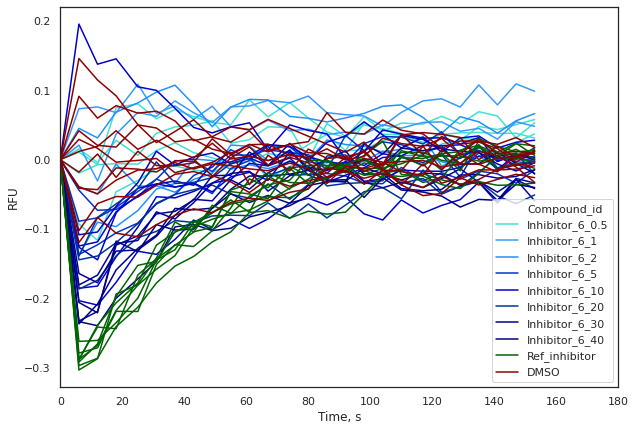

In [11]:
sd.plot_curve_raw(df = ts_data, x = 'Time', y = 'RFU', units = 'Well',
                              hue = 'Compound_id', hue_order = hue_order,
                ylabel = 'RFU', xlabel = 'Time, s',xlimit = 180, palette = palette, 
                save_as = 'dr_raw.png', path = path) 
    

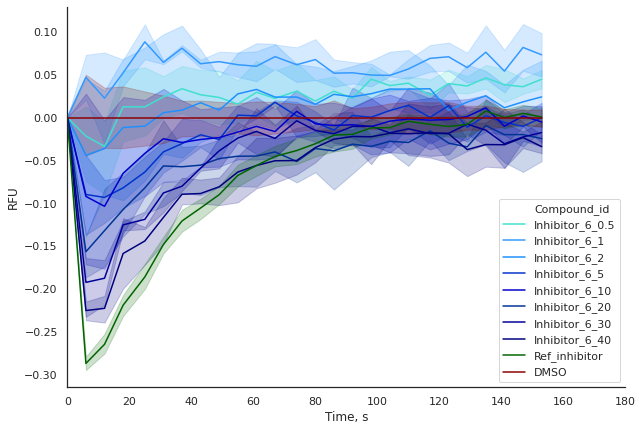

In [12]:
sd.plot_curve_mean(df = ts_data, x = 'Time', y = 'RFU', 
                              hue = 'Compound_id', hue_order = hue_order, 
                 ylabel = 'RFU', xlabel = 'Time, s', xlimit = 180, 
                 palette = palette, save_as = 'dr_mean.png', path = path)


### Calculate slopes
<a id="get_slopes"></a>

* __From the graph we can see that we can calculate the slopes between 0s and 6s.__   
* __We will copy these timepoints to the separate dataframe and calculate the slopes.__
* __Next, we have to divide the slopes by 6, to get the slopes in RFU/sec units.__

In [13]:
slope_data  = data[[0, 6]].transpose()
display(slope_data)

Well,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,...,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,-0.231885,-0.232286,-0.209891,-0.291499,-0.193587,-0.265384,-0.204029,-0.313784,-0.212508,-0.194934,...,-0.287891,-0.303355,-0.019453,-0.12452,-0.168519,-0.136762,-0.126314,-0.044698,-0.164128,-0.128262


#### Calculate slopes and create results DataFrame

In [14]:
slopes = slope_data.apply(lambda x: np.polyfit(slope_data.index, x, 1)[0])/6
results = pd.DataFrame({'Well': data.index, 'slope': slopes.values})
results = sd.add_layout(results, layout_path, chem_path = None, chem_plate = None)
# drop references
results = results[results.Status != 'Reference']
print(results.shape)
display(results.head())

Added  Well
Added  Status
Added  Compound_id
Added  Concentrations
Chemical library not requested
(45, 5)


,Well,slope,Status,Compound_id,Concentrations
10,C2,-0.003320,Negative,DMSO,NaN
11,C3,0.002539,Negative,DMSO,NaN
12,C4,-0.001145,Negative,DMSO,NaN
13,C5,0.000329,Negative,DMSO,NaN
14,C6,0.000813,Negative,DMSO,NaN


Note that we do not perform z-normalization here. Z - normalization is based on mean of the plate samples (random compounds from chemical space), but here we working with preselected hit compounds. 

### Calculate % Inhibition
<a id="inhibition"></a>

Calculate % inhibition at each inhibitor concentration, as follows:

% inhibition = 100 x [1 - (slope - MIN)/(MAX - MIN)]

where MIN is the slope when enzyme is fully inhibited by a control inhibitor, MAX is the slope when the inhibitor concentration is 0, and slope is the slope when treated with the inhibitor.


In [15]:
min_s = results[(results['Status'] == 'Positive')]['slope'].mean()
max_s = results[(results['Status'] == 'Negative')]['slope'].mean()
print(min_s)
print(max_s)
change = lambda x: 100*(1-(x-min_s)/(max_s-min_s))

results['%_inhibition'] = change(results['slope'])

-0.007978389749666838
-6.938893903907229e-19


In [16]:
results.to_csv(path + '//dr_inhibition.csv', index = False)

### Running QC
<a id="qc"></a>

#### Get statistics

In [17]:
stats = sd.sum_statistics(results, 'slope')
display(stats)

,Feature,Status,size,mean,std,var,Z_factor,SB
0,slope,Negative,10.0,-6.938894e-19,0.002281,5.203272e-06,0.012629,1.149807e+16
1,slope,Positive,8.0,-7.978390e-03,0.000345,1.188923e-07,0.012629,1.149807e+16
2,slope,Sample,27.0,-2.746790e-03,0.002990,8.942661e-06,0.012629,1.149807e+16


#### Heatmap

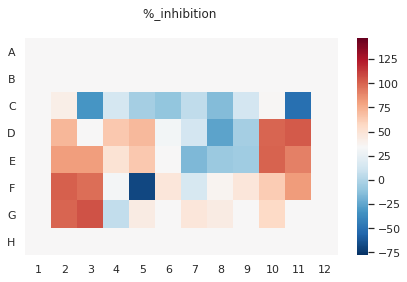

In [18]:
sd.hts_heatmap(df = results, layout_path = layout_path, features = ['%_inhibition'], save_as = 'heatmap.png', path = path)

In [19]:
mean_res = results.groupby('Compound_id').mean().round(2)
mean_res.to_csv(path +'//inhibition.csv')
mean_res

,slope,Concentrations,%_inhibition
Compound_id,,,
DMSO,-0.00,NaN,0.00
Inhibitor_6_0.5,-0.00,0.5,7.51
Inhibitor_6_1,0.00,1.0,-16.44
Inhibitor_6_10,-0.00,7.0,32.06
Inhibitor_6_2,-0.00,2.0,15.31
Inhibitor_6_20,-0.00,20.0,54.57
Inhibitor_6_30,-0.01,30.0,67.03
Inhibitor_6_40,-0.01,40.0,78.50
Inhibitor_6_5,-0.00,5.0,31.29


### Fitting Dose-Response
<a id="dr"></a>

In [20]:
import scipy.optimize as opt
from scipy.stats.stats import pearsonr
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

#### Writing helper functions

In [21]:
def ll4(x,b,c,d,e):
    '''Fitting function - LM equation.
    This function is basically a copy of the LL.4 function (4-parameter sigmoidal function) from the R drc package with
     - b: hill slope
     - c: min response
     - d: max response
     - e: EC50'''
    return(c+(d-c)/(1+np.exp(b*(np.log(x)-np.log(e)))))

def pDose(x): 
    '''Helper function, compute log transformed concentrations.'''
    return(-np.log10(1e-6*x))

def inv_log(x):
    '''Helper function, inverse log calculator'''
    return ((10**-x)/(1e-6))

#### Writing dose-response function

In [22]:
def dose_response(df = None, y_label = 'Response', path = None):
    '''Dose response function. The input DataFrame should contain columns 'Compound_id', 'Dose', 'Response'. 
    The DataFrame shouldn't contain NAN values or dose 0, which will result in infinity at logDose.
    The fitting function is a LL.4 function (4-parameter sigmoidal function) with
     - b: hill slope
     - c: min response
     - d: max response
     - e: EC50
    :param df: pandas DataFrame for plotting.  
    :param y_label: name for y-axis.
    :param path: path to the output folder to save the results, optional.
    :return: DataFrame with Dose Response fitting results.'''
    
    pDose = lambda x:-np.log10(1e-6*x)  # Helper function, compute log transformed concentrations.'
    ll4 = lambda x, b, c, d, e:(c+(d-c)/(1+np.exp(b*(np.log(x)-np.log(e)))))  # fitting function
    
    df = df[['Compound_id', 'Dose', 'Response']].copy()
    df = df[(df != 0).all(1)]  # drop zero values
    df['logDose'] = pDose(df.Dose.astype(float)) # calculate logDose
    df_mean = df.groupby(['Compound_id','Dose'], as_index = False).mean() # calculate response mean values
    df_mean['std'] = list(df.groupby(['Compound_id','Dose']).std()['Response'].values) # calculate response std         
    
    fitData = pd.DataFrame()
    for name, group in df_mean.groupby(['Compound_id']): # group data by compounds
        print(name)   
    # fitting curve
        try:     
                fitCoefs, covMatrix = opt.curve_fit(ll4, group.Dose, group.Response, method = 'lm')
                residuals = group.Response - group.Dose.apply(lambda x: ll4(x,*fitCoefs))
                curFit = dict(zip(['b','c','d','e'], fitCoefs))
                curFit['Compound_id'], curFit['residuals'] = name, sum(residuals**2)
                predicted = group.Dose.apply(lambda x: ll4(x,*fitCoefs))
                curFit['r_squared'] = pearsonr(group.Response, predicted)[0]**2
                curFit['N'] =  int(group.shape[0])
                fitData = fitData.append(curFit, ignore_index = True)
                EC50_response = ll4(curFit['e'],*[curFit[i] for i in ['b','c','d','e']])

                # plot data 
                raw = df[df.Compound_id == name]
                refDose = np.linspace(min(raw.Dose)*0.55, max(raw.Dose)*1.6, 256)
                g2 = sns.lmplot('logDose', 'Response', data = group,  fit_reg = False, legend = False, height=6)
                g2.map(plt.errorbar, 'logDose', 'Response',yerr = group['std'], fmt='o')
                axes = plt.gca()
                axes.invert_xaxis()
                plt.plot([pDose(i) for i in refDose],[ll4(i,*[curFit[i] for i in ['b','c','d','e']]) for i in refDose])
                locs, labels = plt.xticks()
                g2.set_xticklabels([round(inv_log(l), 1) for l in locs]) # inverse log for xticks
                plt.xlabel('Dose (um)')
                plt.ylabel(y_label)
                plt.title(name)
                
                #plot EC_50_label 
                ymin, ymax = axes.get_ylim()
                xmin, xmax = axes.get_xlim()
                plt.plot([xmin, pDose(curFit['e'])], [EC50_response, EC50_response], color = 'navy', linestyle = '--', lw = 0.7)
                plt.plot([pDose(curFit['e']), pDose(curFit['e'])], [ymin, EC50_response], color = 'navy', linestyle = '--', lw = 0.7)
                plt.show()
                
                if path:
                    g2.savefig(path +'//' + name +'_dr_fit.png', bbox_inches='tight', dpi=600)
                
                plt.close()

        except Exception as e:
                print('Fitting curve failed:')
                print(e)
   
    if not fitData.empty: 
        fitData = fitData.set_index('Compound_id') # .round(2)
        fitData['N'] = fitData.N.astype(int)
        fitData.rename(columns = {'b': 'hill slope', 'c': 'min response', 'd': 'max response', 'e': 'EC50'}, inplace = True)
        return fitData

In [23]:
dr_data = results.dropna(subset = ['Concentrations']).copy() 
dr_data.rename(columns = {'%_inhibition' : 'Response'}, inplace = True)
dr_data.rename(columns = {'Concentrations' : 'Dose'}, inplace = True)
dr_data.Compound_id = 'Inhibitor_6'
print(dr_data .shape)
display(dr_data.head(3))

(27, 6)


,Well,slope,Status,Compound_id,Dose,Response
20,D2,-0.005720,Sample,Inhibitor_6,40.0,71.688565
22,D4,-0.005185,Sample,Inhibitor_6,20.0,64.991929
23,D5,-0.005649,Sample,Inhibitor_6,10.0,70.808575


Inhibitor_6


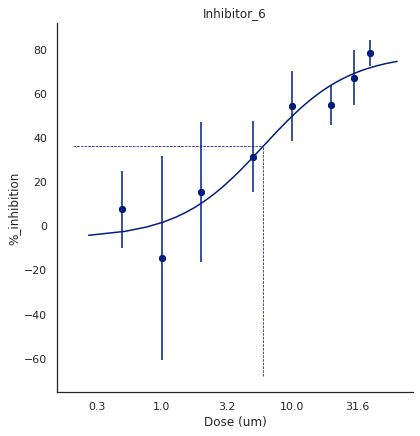

In [24]:
fitTable = dose_response(df = dr_data, y_label = '%_inhibition', path = path)
if not fitTable.empty:
    fitTable.to_csv(path + '//fitTable.csv')

### Polynomial Fit
<a id="poly"></a>
If fitting hill equation failed, we can plot polynomial fit just to visualize our data

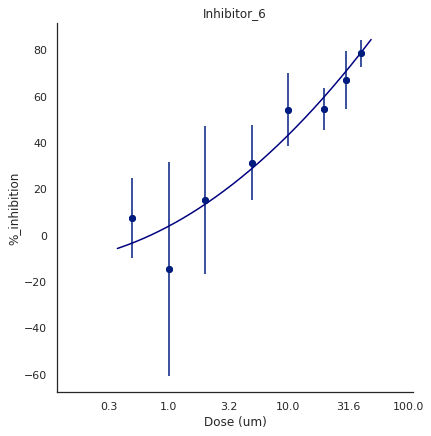

In [25]:
sd.plot_polynomial(df = dr_data, y_label = '%_inhibition',  degree = 2, path = path)

#### Create ppt and html reports and clean output folder

In [26]:
report = sd.create_presentation(path).save(path +'//dr_report.pptx')

In [27]:
# Save notebook as html for reporting
! jupyter nbconvert --to html 02c_ion_channel_dose_response.ipynb

[NbConvertApp] Converting notebook 02c_ion_channel_dose_response.ipynb to html
[NbConvertApp] Writing 817223 bytes to 02c_ion_channel_dose_response.html


In [28]:
# Clean pictures from output folder
for f in os.listdir(path):
    if '.png' in f:
        os.remove(path +'//' + f)

### Conclusions
<a id="conclusions"></a>

We successfully fitted dose response curve showing IC50 about 6um to our compound. We can take this compound for further optimization.